# Assignment 8: DT

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   <li><b>Task 2: </b>For this task consider set-1 features. Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from math import log
from wordcloud import WordCloud, STOPWORDS

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [5]:
data = pd.read_csv('preprocessed_data.csv')
print(data.shape)
data.head()

(109248, 9)


school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   
3    appliedlearning                    earlydevelopment   
4  literacy_language                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00  
3  i recently read article giving students choice...  481.04  
4  my students crave challenge eat obstacles brea...   17.74

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   school_state                                  109248 non-null  object 
 1   teacher_prefix                                109248 non-null  object 
 2   project_grade_category                        109248 non-null  object 
 3   teacher_number_of_previously_posted_projects  109248 non-null  int64  
 4   project_is_approved                           109248 non-null  int64  
 5   clean_categories                              109248 non-null  object 
 6   clean_subcategories                           109248 non-null  object 
 7   essay                                         109248 non-null  object 
 8   price                                         109248 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 

In [4]:
print(data.columns)
data['project_is_approved'].value_counts()

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


1    92706
0    16542
Name: project_is_approved, dtype: int64

### CONVERTING 'SCHOOL_STATE' INTO NUMERICAL FEATURE

In [5]:
j = dict(data['school_state'].value_counts())
true, false = 0, 0
l = {} 
for key, value in j.items():
    sum, neg, = 0, 0
    for state, y in zip(data['school_state'], data['project_is_approved']):
        if (key == state and y == 1):
            sum+= 1
    true = sum / value
    l[key] = true

for key, value in l.items():
    data['school_state'].replace(to_replace = key, value = value, inplace = True)



### CONVERTING 'CLEAN_CATEGORIES' INTO NUMERICAL FEATURE

In [6]:
j = dict(data['clean_categories'].value_counts())
true, false = 0, 0
l = {} 
for key, value in j.items():
    sum, neg, = 0, 0
    for state, y in zip(data['clean_categories'], data['project_is_approved']):
        if (key == state and y == 1):
            sum+= 1
    true = sum / value
    l[key] = true

for key, value in l.items():
    data['clean_categories'].replace(to_replace = key, value = value, inplace = True)

### CONVERTING 'CLEAN_SUBCATEGORIES' INTO NUMERICAL FEATURE

In [7]:
j = dict(data['clean_subcategories'].value_counts())
true, false = 0, 0
l = {} 
for key, value in j.items():
    sum, neg, = 0, 0
    for state, y in zip(data['clean_subcategories'], data['project_is_approved']):
        if (key == state and y == 1):
            sum+= 1
    true = sum / value
    l[key] = true

for key, value in l.items():
    data['clean_subcategories'].replace(to_replace = key, value = value, inplace = True)

In [8]:
data.head()

school_state teacher_prefix project_grade_category  \
0      0.874622            mrs          grades_prek_2   
1      0.826667             ms             grades_3_5   
2      0.874622            mrs          grades_prek_2   
3      0.875648            mrs          grades_prek_2   
4      0.895161            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

   clean_categories  clean_subcategories  \
0          0.842711             0.771429   
1          0.874214             0.874214   
2          0.868112             0.885584   
3          0.873786             1.000000   
4          0.868112             0.885584   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00  
3  i recently read article giving students choice...  481.04  
4  my students crave challenge eat obstacles brea...   17.74

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [8]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [9]:
Y = data['project_is_approved'].values
X = data.drop('project_is_approved', axis = 1)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, stratify = Y)
#X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size = 0.33, stratify = Y_train)
#print(X_train.shape, Y_train.shape)
#print(X_cv.shape, Y_cv.shape)
#print(X_test.shape, Y_test.shape)
#X_train.head()

### UPSAMPLING OF MINORITY CLASS

In [10]:
i = Y.copy()
j = X.copy()
i.shape, j.shape

((109248,), (109248, 8))

In [11]:
j = np.asarray(j)

In [12]:
i_class0 = np.where(Y == 0)[0]
i_class1 = np.where(Y == 1)[0]
n0 = len(i_class0)
n1 = len(i_class1)
i_class0_up = np.random.choice(i_class0, size = n1, replace = True)
o = np.concatenate((i[i_class0_up], i[i_class1]))
p = np.concatenate((j[i_class0_up], j[i_class1]))
o.shape, p.shape

((185412,), (185412, 8))

In [13]:
p = pd.DataFrame(p, columns = X.columns)

In [14]:
p['school_state'] = p['school_state'].astype(np.float64)
p['clean_categories'] = p['clean_categories'].astype(np.float64)
p['clean_subcategories'] = p['clean_subcategories'].astype(np.float64)
p['teacher_number_of_previously_posted_projects'] = p['teacher_number_of_previously_posted_projects'].astype(np.int64)
p['price'] = p['price'].astype(np.float64)
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185412 entries, 0 to 185411
Data columns (total 8 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   school_state                                  185412 non-null  float64
 1   teacher_prefix                                185412 non-null  object 
 2   project_grade_category                        185412 non-null  object 
 3   teacher_number_of_previously_posted_projects  185412 non-null  int64  
 4   clean_categories                              185412 non-null  float64
 5   clean_subcategories                           185412 non-null  float64
 6   essay                                         185412 non-null  object 
 7   price                                         185412 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 11.3+ MB


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(p, o, test_size = 0.33, stratify = o)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size = 0.23, stratify = Y_train)
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)
p.head()

(95654, 8) (95654,)
(28572, 8) (28572,)
(61186, 8) (61186,)


school_state teacher_prefix project_grade_category  \
0      0.831690            mrs          grades_prek_2   
1      0.860193             ms            grades_9_12   
2      0.855038            mrs          grades_prek_2   
3      0.850242             mr          grades_prek_2   
4      0.831690             ms          grades_prek_2   

   teacher_number_of_previously_posted_projects  clean_categories  \
0                                             0          0.869432   
1                                             9          0.834437   
2                                             6          0.814638   
3                                             4          0.867470   
4                                             0          0.819529   

   clean_subcategories                                              essay  \
0             0.872072  i teach low income title 1 school families str...   
1             0.834437  full inclusion students make everyday unique s...   
2             0.805471  we unique special little tigers k 5 elementary...   
3             0.852018  our classroom unique we made roughly 28 studen...   
4             0.830833  my students four five year olds going kinderga...   

    price  
0   11.87  
1  714.27  
2  173.85  
3  657.46  
4  397.98

<h2>1.3 Make Data Model Ready: encoding essay</h2>

## TASK - 1 SET - 1 USING TFIDF 

In [16]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,3), max_features=5000 )

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

print("="*100)


vectorizer.fit(X_train['essay']) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'])
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'])
X_test_essay_tfidf = vectorizer.transform(X_test['essay'])

print("After vectorizations")
print(X_train_essay_tfidf.shape, Y_train.shape)
print(X_cv_essay_tfidf.shape, Y_cv.shape)
print(X_test_essay_tfidf.shape, Y_test.shape)
print("="*100)
#print(vectorizer.get_feature_names())

(95654, 8) (95654,)
(28572, 8) (28572,)
(61186, 8) (61186,)
After vectorizations
(95654, 5000) (95654,)
(28572, 5000) (28572,)
(61186, 5000) (61186,)


<h2>1.4 Make Data Model Ready: encoding categorical features</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### ENCODING 'TEACHER_PREFIX' CATEGORY

In [18]:
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, Y_train.shape)
print(X_cv_teacher_ohe.shape, Y_cv.shape)
print(X_test_teacher_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

TP = vectorizer.get_feature_names()

(95654, 8) (95654,)
(28572, 8) (28572,)
(61186, 8) (61186,)
After vectorizations
(95654, 5) (95654,)
(28572, 5) (28572,)
(61186, 5) (61186,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### ENCODING 'PROJECT_GRADE_CATEGORY'

In [19]:
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

print("="*100)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, Y_train.shape)
print(X_cv_grade_ohe.shape, Y_cv.shape)
print(X_test_grade_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

PGC = vectorizer.get_feature_names()

(95654, 8) (95654,)
(28572, 8) (28572,)
(61186, 8) (61186,)
After vectorizations
(95654, 4) (95654,)
(28572, 4) (28572,)
(61186, 4) (61186,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [20]:
from scipy.sparse import csr_matrix
#p = data['school_state'].values
X_train_state_ohe = csr_matrix( X_train['school_state'].values).T
X_cv_state_ohe = csr_matrix( X_cv['school_state'].values).T
X_test_state_ohe = csr_matrix( X_test['school_state'].values).T

X_train_cat = csr_matrix(X_train['clean_categories'].values).T
X_cv_cat= csr_matrix( X_cv['clean_categories'].values).T
X_test_cat = csr_matrix( X_test['clean_categories'].values).T
    
X_train_sub_cat = csr_matrix(X_train['clean_subcategories'].values).T
X_cv_sub_cat= csr_matrix( X_cv['clean_subcategories'].values).T
X_test_sub_cat = csr_matrix( X_test['clean_subcategories'].values).T    

# Since DT is not based on Distance Metric Normalization does'nt plays vital role
X_train_posted_ohe = csr_matrix( X_train['teacher_number_of_previously_posted_projects'].values).T
X_cv_posted_ohe = csr_matrix( X_cv['teacher_number_of_previously_posted_projects'].values).T
X_test_posted_ohe = csr_matrix( X_test['teacher_number_of_previously_posted_projects'].values).T

X_train_price_norm = csr_matrix(X_train['price'].values).T
X_cv_price_norm = csr_matrix(X_cv['price'].values).T
X_test_price_norm = csr_matrix(X_test['price'].values).T



In [21]:

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_posted_ohe, X_train_cat, X_train_sub_cat, X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_posted_ohe, X_cv_cat, X_cv_sub_cat, X_cv_price_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_posted_ohe, X_test_cat, X_test_sub_cat, X_test_price_norm)).tocsr()


print("Final Data matrix")
print(X_tr.shape, Y_train.shape)
print(X_cr.shape, Y_cv.shape)
print(X_te.shape, Y_test.shape)
print("="*100)

Final Data matrix
(95654, 5014) (95654,)
(28572, 5014) (28572,)
(61186, 5014) (61186,)


<h2>1.5 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [22]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label


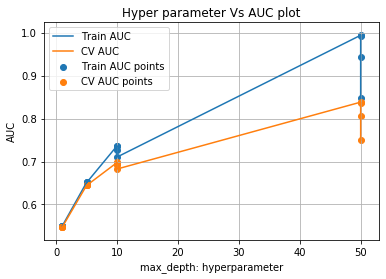

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.238368      0.046975         0.057645        0.008258   
1       4.272541      0.024489         0.053257        0.004619   
2       4.228818      0.038623         0.052461        0.005187   
3       4.204703      0.007292         0.051861        0.005917   
4      17.997992      0.059635         0.053457        0.007372   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.546114   
1   {'max_depth': 1, 'min_samples_split': 10}           0.546114   
2  {'max_depth': 1, 'min_samples_split': 100}           0.546114   
3  {'max_depth': 1, 'min_samples_split': 500}           0.546114   
4    {'max_depth': 5, 'min_samples_split': 5}           0.640738   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
0           0.550224           0.547994  ...         0.547435        0.001592   
1           0.550224           0.547994  ...         0.547435        0.001592   
2           0.550224           0.547994  ...         0.547435        0.001592   
3           0.550224           0.547994  ...         0.547435        0.001592   
4           0.646531           0.645142  ...         0.644656        0.003090   

   rank_test_score  split0_train_score  split1_train_score  \
0               13            0.554896            0.549046   
1               13            0.554896            0.549046   
2               13            0.554896            0.549046   
3               13            0.554896            0.549046   
4                9            0.654465            0.652432   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.549133            0.547788            0.549370   
1            0.549133            0.547788            0.549370   
2            0.549133            0.547788            0.549370   
3            0.549133            0.547788            0.549370   
4            0.648490            0.652100            0.650374   

   mean_train_score  std_train_score  
0          0.550047         0.002486  
1          0.550047         0.002486  
2          0.550047         0.002486  
3          0.550047         0.002486  
4          0.651572         0.002016  

[5 rows x 22 columns]

In [23]:
DT = DecisionTreeClassifier(criterion='entropy', random_state=0)
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
#clf = GridSearchCV(DT, parameters, cv=5, scoring='roc_auc', n_jobs = -1, return_train_score= True)

clf.fit(X_tr, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']


plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(5)

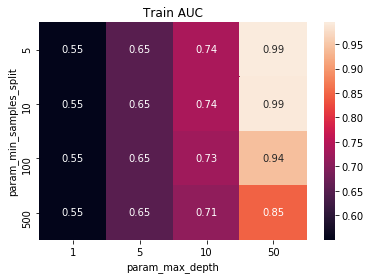

In [24]:
# Code is referred from seaborn.heatmap documentation
result = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_train_score')
sns.heatmap(result, annot = True)
plt.title("Train AUC")
plt.show()

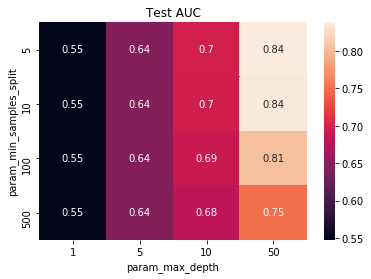

In [25]:
# Code is referred from seaborn.heatmap documentation
result = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_test_score')
sns.heatmap(result, annot = True)
plt.title("Test AUC")
plt.show()

In [33]:
best_depth = 50; best_split = 100
DT = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth = best_depth, min_samples_split = best_split)
DT.fit(X_tr, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [34]:
y_pred_tr = DT.predict_proba(X_tr)[:, 1]
y_pred_te = DT.predict_proba(X_te)[:, 1]

In [35]:
print("AUC Score of Train: ", roc_auc_score(Y_train, y_pred_tr),"AUC Score of Test: ", roc_auc_score(Y_test, y_pred_te))

AUC Score of Train:  0.9482801815003497 AUC Score of Test:  0.8297387676009661


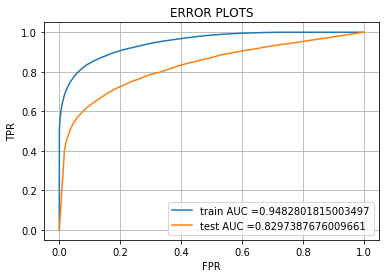

In [36]:
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_pred_te)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [37]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.7594431870990426 for threshold 0.488


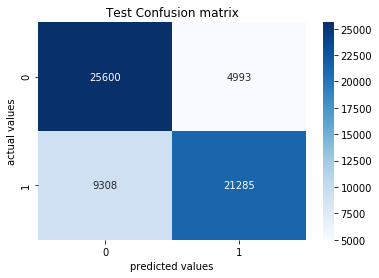

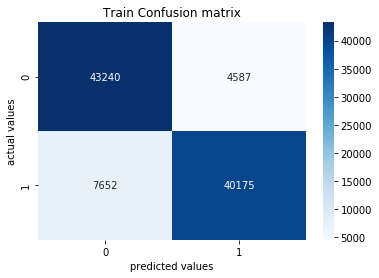

In [38]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_con=confusion_matrix(Y_test, predict_with_best_t(y_pred_te, best_t)) 
sns.heatmap(test_con,annot=True,cmap='Blues', fmt="d") 
plt.xlabel("predicted values") 
plt.ylabel("actual values") 
plt.title("Test Confusion matrix") 
plt.show()


train_con=confusion_matrix(Y_train, predict_with_best_t(y_pred_tr, best_t)) 
sns.heatmap(train_con,annot=True,cmap='Blues', fmt="d") 
plt.xlabel("predicted values") 
plt.ylabel("actual values") 
plt.title("Train Confusion matrix") 
plt.show()


In [39]:
# Getting False Positive Test points
y_pred_test = predict_with_best_t(y_pred_te, best_t)
idx = []
for (index, y), y_pred in zip(enumerate(Y_test), y_pred_test):
    if y == 0 and y_pred == 1:
        idx.append(index)
print(len(idx))
text = []
posted = []
for index in idx:
    text.append(X_test.iloc[index, 6])
    posted.append(X_test.iloc[index, 3])

4993


In [40]:
# Word Cloud of text in essay of False Positive Test Points
# Code is referred from https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ''
stopwords = set(STOPWORDS)

for texts in text:
    texts = str(texts)
    
    tokens = texts.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens) + " "

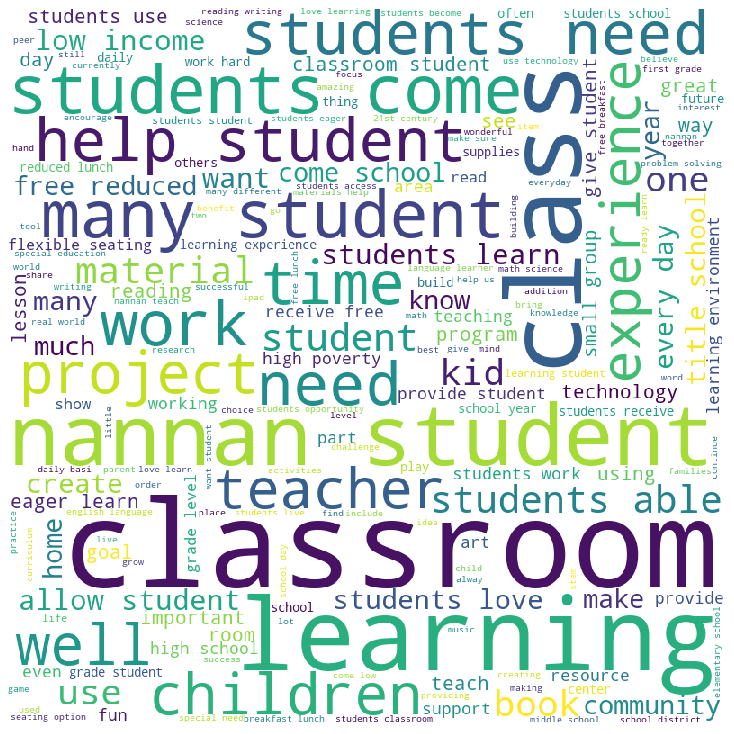

In [41]:
# Code is referred from https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

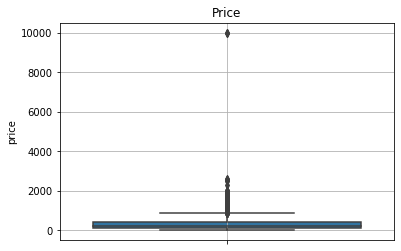

In [42]:
# Box plot of Price of False Positive Test Points
sns.boxplot(y = 'price', data = X_test.iloc[idx])
plt.title('Price')
plt.grid(True)
plt.show()

[9.14480272e-01 4.70658922e-02 1.66232726e-02 6.00841178e-03
 9.41317845e-03 3.20448628e-03 2.00280393e-04 1.60224314e-03
 1.20168236e-03 2.00280393e-04]
[  0.   26.2  52.4  78.6 104.8 131.  157.2 183.4 209.6 235.8 262. ]


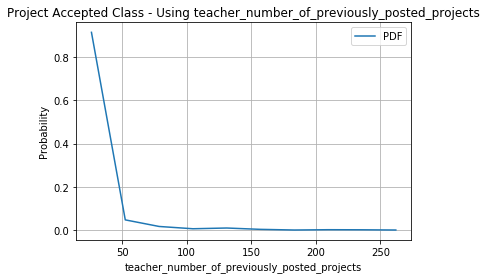

In [43]:
# PDF plot of teacher_number_of_previously_posted_projects of False Positive Test Points
counts, bin_edges = np.histogram(posted, bins=10, 
                                 density = True)
pdf = counts/(np.sum(counts))
print(pdf)
print(bin_edges)

plt.plot(bin_edges[1:],pdf, label = 'PDF')
plt.legend()
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('Probability')
plt.title('Project Accepted Class - Using teacher_number_of_previously_posted_projects')
plt.grid(True)
plt.show()

## TASK -2 GETTING FEATURE IMPORTANCES USING SET - 1 AND PERFORMING CLASSIFICATION

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [44]:
DT1 = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth = None, min_samples_split = 100)
DT1.fit(X_tr, Y_train)
features = DT1.feature_importances_

In [45]:
# Getting Non-zero Features
new_feat = []
for label, feat in enumerate(features):
    if (feat != 0):
        new_feat.append(label)
print("No. of non-zero features: ", len(new_feat))    

No. of non-zero features:  1582


In [46]:
X_tr_new = X_tr[:, new_feat]
X_cr_new = X_cr[:, new_feat]
X_te_new = X_te[:, new_feat]
print("Final Data matrix")
print(X_tr_new.shape, Y_train.shape)
print(X_cr_new.shape, Y_cv.shape)
print(X_te_new.shape, Y_test.shape)
print("="*100)

Final Data matrix
(95654, 1582) (95654,)
(28572, 1582) (28572,)
(61186, 1582) (61186,)


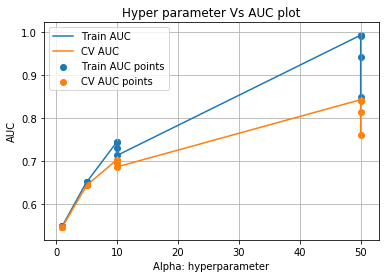

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.628723      0.613644         0.029536        0.013293   
1       2.563654      0.026021         0.020146        0.001397   
2       2.558873      0.035854         0.020776        0.003401   
3       2.629078      0.064675         0.020845        0.002617   
4      11.042667      0.072289         0.023139        0.006537   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.540351   
1   {'max_depth': 1, 'min_samples_split': 10}           0.540351   
2  {'max_depth': 1, 'min_samples_split': 100}           0.540351   
3  {'max_depth': 1, 'min_samples_split': 500}           0.540351   
4    {'max_depth': 5, 'min_samples_split': 5}           0.631679   

   split1_test_score  split2_test_score  ...  split2_train_score  \
0           0.551641           0.549550  ...            0.549252   
1           0.551641           0.549550  ...            0.549252   
2           0.551641           0.549550  ...            0.549252   
3           0.551641           0.549550  ...            0.549252   
4           0.645668           0.644923  ...            0.651151   

   split3_train_score  split4_train_score  split5_train_score  \
0            0.548799            0.549195             0.54880   
1            0.548799            0.549195             0.54880   
2            0.548799            0.549195             0.54880   
3            0.548799            0.549195             0.54880   
4            0.651631            0.651589             0.65011   

   split6_train_score  split7_train_score  split8_train_score  \
0            0.547697            0.548878            0.548762   
1            0.547697            0.548878            0.548762   
2            0.547697            0.548878            0.548762   
3            0.547697            0.548878            0.548762   
4            0.651754            0.652225            0.652272   

   split9_train_score  mean_train_score  std_train_score  
0            0.549459          0.549430         0.001866  
1            0.549459          0.549430         0.001866  
2            0.549459          0.549430         0.001866  
3            0.549459          0.549430         0.001866  
4            0.654423          0.652253         0.001275  

[5 rows x 32 columns]

In [47]:
#svc = SVC(kernel = 'linear', random_state = 0)
#sgd = SGDClassifier(loss = 'log', n_jobs = -1,  ﬁt_intercept=True, penalty = 'l1', learning_rate = 'adaptive', eta0 = 0.001)
#lr = LogisticRegression(n_jobs = -1) 
DT = DecisionTreeClassifier(criterion='gini', random_state=0)
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
#parameters = {'C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
#parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 1000], 'eta0': [1e-3, 1e-2, 1e-1, 1, 10, 1000]}
clf = GridSearchCV(DT, parameters, cv=10, scoring='roc_auc', n_jobs = -1, return_train_score= True)
clf.fit(X_tr_new, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']


plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(5)

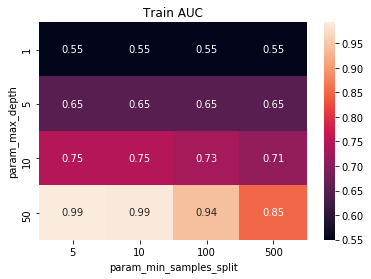

In [48]:
# Code is referred from seaborn.heatmap documentation
result = results.pivot('param_max_depth', 'param_min_samples_split', 'mean_train_score')
sns.heatmap(result, annot = True)
plt.title("Train AUC")
plt.show()

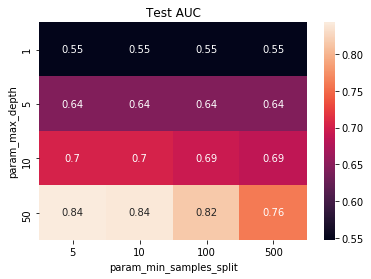

In [49]:
# Code is referred from seaborn.heatmap documentation
result = results.pivot('param_max_depth', 'param_min_samples_split', 'mean_test_score')
sns.heatmap(result, annot = True)
plt.title("Test AUC")
plt.show()

In [51]:
best_depth = 50; best_split = 100
DT2 = DecisionTreeClassifier(criterion='gini', random_state=0, max_depth = best_depth, min_samples_split = best_split)
DT2.fit(X_tr_new, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [52]:
y_pred_tr = DT2.predict_proba(X_tr_new)[:, 1]
y_pred_te = DT2.predict_proba(X_te_new)[:, 1]

In [53]:
from sklearn.metrics import roc_curve, auc, accuracy_score,  roc_auc_score 
print("AUC Score of Train: ", roc_auc_score(Y_train, y_pred_tr),"AUC Score of Test: ", roc_auc_score(Y_test, y_pred_te))

AUC Score of Train:  0.9447293687285446 AUC Score of Test:  0.8276551726054516


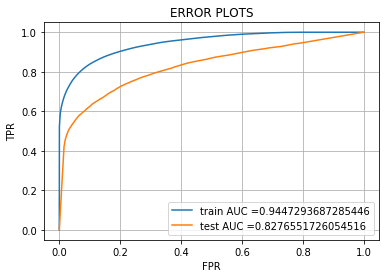

In [54]:
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_pred_te)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [55]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.7547514838046304 for threshold 0.495


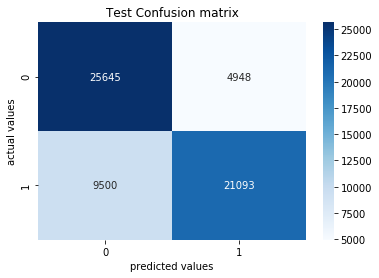

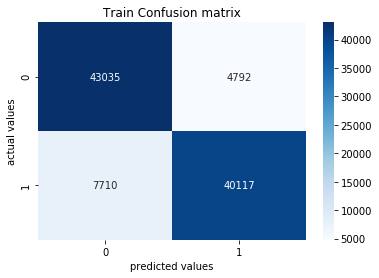

In [56]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_con=confusion_matrix(Y_test, predict_with_best_t(y_pred_te, best_t)) 
sns.heatmap(test_con,annot=True,cmap='Blues', fmt="d") 
plt.xlabel("predicted values") 
plt.ylabel("actual values") 
plt.title("Test Confusion matrix") 
plt.show()


train_con=confusion_matrix(Y_train, predict_with_best_t(y_pred_tr, best_t)) 
sns.heatmap(train_con,annot=True,cmap='Blues', fmt="d") 
plt.xlabel("predicted values") 
plt.ylabel("actual values") 
plt.title("Train Confusion matrix") 
plt.show()

# TASK - 1 -  SET - 2 USING TFIDFW2V

In [57]:
Essays = [X_train['essay'].values, X_cv['essay'].values, X_test['essay'].values]

In [58]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [59]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [60]:
# average Word2Vec
# compute average word2vec for each review.
#tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
tfidf_final = []
for essays in Essays:
    tfidf_w2v_vectors = []
    for sentence in tqdm(essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    tfidf_final.append(np.array(tfidf_w2v_vectors))

#print(len(tfidf_w2v_vectors))
#print(len(tfidf_w2v_vectors[0]))
#print(len(tfidf_final))

100%|███████████████████████████████████████████████████████████████████████████| 61186/61186 [02:30<00:00, 407.77it/s]


In [61]:
tfidf_final = np.array(tfidf_final)

In [62]:
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

print("="*100)

X_train_essay_tfidf_w2v = tfidf_final[0]
X_cv_essay_tfidf_w2v = tfidf_final[1]
X_test_essay_tfidf_w2v = tfidf_final[2]


print("After vectorizations")
print(X_train_essay_tfidf_w2v.shape, Y_train.shape)
print(X_cv_essay_tfidf_w2v.shape, Y_cv.shape)
print(X_test_essay_tfidf_w2v.shape, Y_test.shape)
print("="*100)

(95654, 8) (95654,)
(28572, 8) (28572,)
(61186, 8) (61186,)
After vectorizations
(95654, 300) (95654,)
(28572, 300) (28572,)
(61186, 300) (61186,)


In [63]:
from scipy.sparse import hstack
X_tr1 = hstack((X_train_essay_tfidf_w2v, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_posted_ohe, X_train_cat, X_train_sub_cat, X_train_price_norm)).tocsr()
X_cr1 = hstack((X_cv_essay_tfidf_w2v, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_posted_ohe, X_cv_cat, X_cv_sub_cat, X_cv_price_norm)).tocsr()
X_te1 = hstack((X_test_essay_tfidf_w2v, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_posted_ohe, X_test_cat, X_test_sub_cat, X_test_price_norm)).tocsr()


print("Final Data matrix")
print(X_tr1.shape, Y_train.shape)
print(X_cr1.shape, Y_cv.shape)
print(X_te1.shape, Y_test.shape)
print("="*100)

Final Data matrix
(95654, 314) (95654,)
(28572, 314) (28572,)
(61186, 314) (61186,)


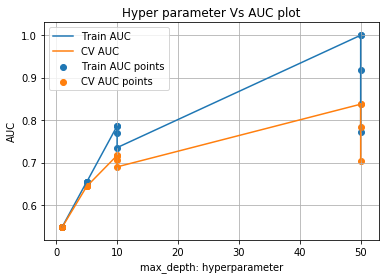

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      62.446271     22.503404         1.836556        0.870907   
1      14.143550      4.130856         0.097986        0.012030   
2       9.622197      0.394214         0.109327        0.006800   
3       9.720414      0.090902         0.109571        0.019969   
4      39.923596      0.294034         0.101129        0.018208   

  param_max_depth param_min_samples_split  \
0               1                       5   
1               1                      10   
2               1                     100   
3               1                     500   
4               5                       5   

                                       params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 5}           0.550120   
1   {'max_depth': 1, 'min_samples_split': 10}           0.550120   
2  {'max_depth': 1, 'min_samples_split': 100}           0.550120   
3  {'max_depth': 1, 'min_samples_split': 500}           0.550120   
4    {'max_depth': 5, 'min_samples_split': 5}           0.641071   

   split1_test_score  split2_test_score  ...  mean_test_score  std_test_score  \
0           0.550224           0.547994  ...         0.548236        0.001728   
1           0.550224           0.547994  ...         0.548236        0.001728   
2           0.550224           0.547994  ...         0.548236        0.001728   
3           0.550224           0.547994  ...         0.548236        0.001728   
4           0.646834           0.648127  ...         0.643712        0.004080   

   rank_test_score  split0_train_score  split1_train_score  \
0               13            0.548602            0.549046   
1               13            0.548602            0.549046   
2               13            0.548602            0.549046   
3               13            0.548602            0.549046   
4                9            0.655824            0.650840   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.549133            0.547788            0.549370   
1            0.549133            0.547788            0.549370   
2            0.549133            0.547788            0.549370   
3            0.549133            0.547788            0.549370   
4            0.654901            0.652833            0.658291   

   mean_train_score  std_train_score  
0          0.548788         0.000559  
1          0.548788         0.000559  
2          0.548788         0.000559  
3          0.548788         0.000559  
4          0.654538         0.002548  

[5 rows x 22 columns]

In [64]:
DT = DecisionTreeClassifier(criterion='entropy', random_state=0)
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
clf = GridSearchCV(DT, parameters, cv=5, scoring='roc_auc', n_jobs = -1, return_train_score= True)
clf.fit(X_tr1, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']


plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(5)

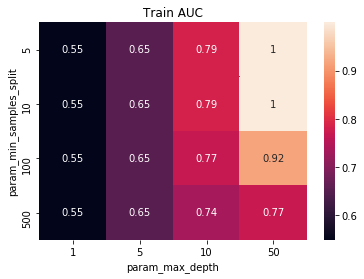

In [65]:
# Code is referred from seaborn.heatmap documentation
result = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_train_score')
sns.heatmap(result, annot = True)
plt.title("Train AUC")
plt.show()

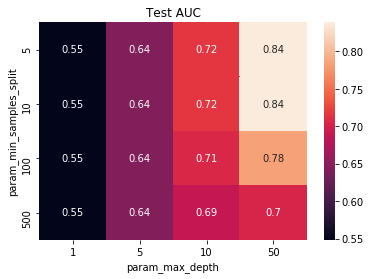

In [66]:
# Code is referred from seaborn.heatmap documentation
result = results.pivot('param_min_samples_split', 'param_max_depth', 'mean_test_score')
sns.heatmap(result, annot = True)
plt.title("Test AUC")
plt.show()

In [70]:
best_depth = 50; best_split = 100
DT = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth = best_depth, min_samples_split = best_split)
DT.fit(X_tr1, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [71]:
y_pred_tr = DT.predict_proba(X_tr1)[:, 1]
y_pred_te = DT.predict_proba(X_te1)[:, 1]

In [72]:
print("AUC Score of Train: ", roc_auc_score(Y_train, y_pred_tr), "AUC Score of Test: ", roc_auc_score(Y_test, y_pred_te))

AUC Score of Train:  0.9316447521037996 AUC Score of Test:  0.8132681385582677


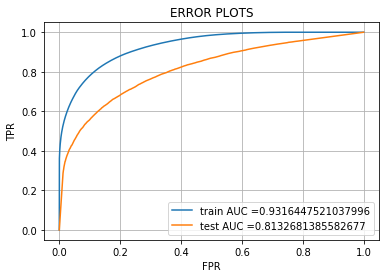

In [73]:
train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_pred_te)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [74]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.7136312541664017 for threshold 0.5


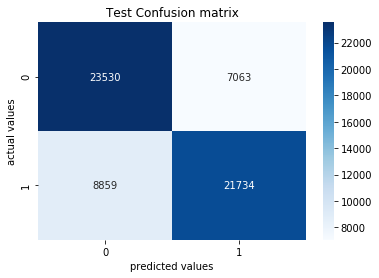

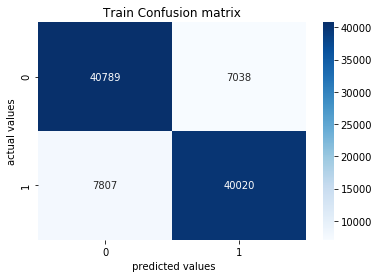

In [75]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
test_con=confusion_matrix(Y_test, predict_with_best_t(y_pred_te, best_t)) 
sns.heatmap(test_con,annot=True,cmap='Blues', fmt="d") 
plt.xlabel("predicted values") 
plt.ylabel("actual values") 
plt.title("Test Confusion matrix") 
plt.show()


train_con=confusion_matrix(Y_train, predict_with_best_t(y_pred_tr, best_t)) 
sns.heatmap(train_con,annot=True,cmap='Blues', fmt="d") 
plt.xlabel(" predicted values") 
plt.ylabel("actual values") 
plt.title("Train Confusion matrix") 
plt.show()


In [76]:
# Getting False Positive Points of Test data
y_pred_test = predict_with_best_t(y_pred_te, best_t)
idx = []
for (index, y), y_pred in zip(enumerate(Y_test), y_pred_test):
    if y == 0 and y_pred == 1:
        idx.append(index)
text = []
posted = []
for index in idx:
    text.append(X_test.iloc[index, 6])
    posted.append(X_test.iloc[index, 3])

In [77]:
len(idx)

7063

In [78]:
# Word Cloud of text in essay of False Positive Test Points
# Code is referred from https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ''
stopwords = set(STOPWORDS)

for texts in text:
    texts = str(texts)
    
    tokens = texts.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    comment_words += " ".join(tokens) + " "

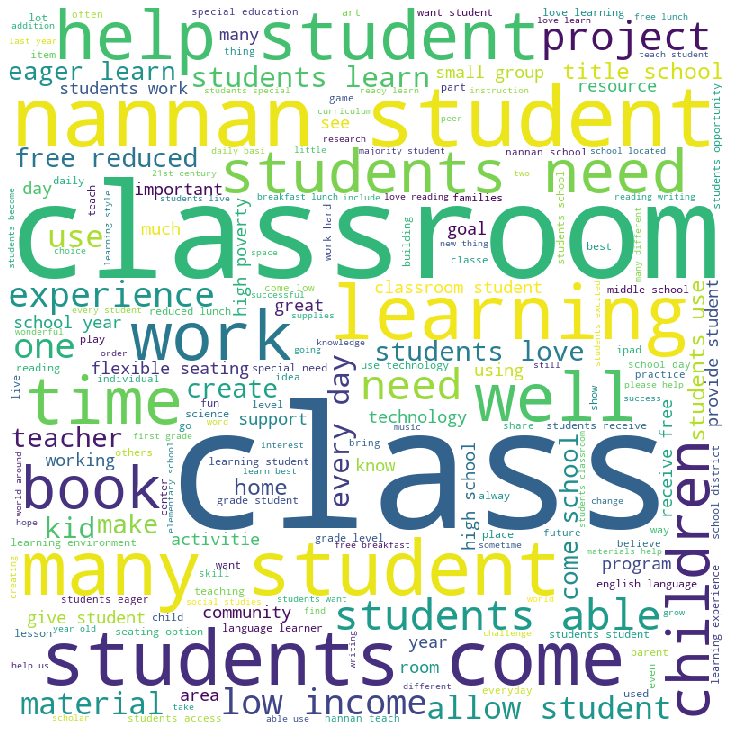

In [79]:
#Code is referred from https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

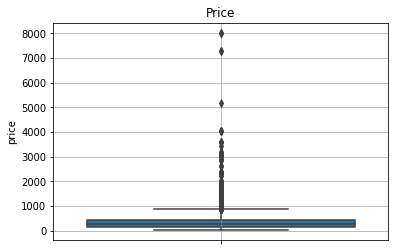

In [80]:
# Box plot of Price of False Positive Test Points
sns.boxplot(y = 'price', data = X_test.iloc[idx])
plt.title('Price')
plt.grid(True)
plt.show()

[9.43508424e-01 3.15729860e-02 1.06187173e-02 9.48605408e-03
 2.54849214e-03 7.07914484e-04 5.66331587e-04 1.41582897e-04
 0.00000000e+00 8.49497381e-04]
[  0.   34.3  68.6 102.9 137.2 171.5 205.8 240.1 274.4 308.7 343. ]


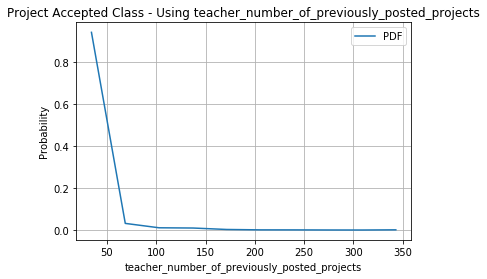

In [81]:
# PDF plot of teacher_number_of_previously_posted_projects of False Positive Test Points
counts, bin_edges = np.histogram(posted, bins=10, 
                                 density = True)
pdf = counts/(np.sum(counts))
print(pdf)
print(bin_edges)

plt.plot(bin_edges[1:],pdf, label = 'PDF')
plt.legend()
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('Probability')
plt.title('Project Accepted Class - Using teacher_number_of_previously_posted_projects')
plt.grid(True)
plt.show()

<h1>2. Summary</h1>

| Vectorizer | Model  | hyperparameter max_depth | hyperparameter min_samples_split |test AUC|
|------------|--------|---------------------- |----------------------|--------|
|    TFIDF   |    DT  |           50        |   100 |   0.8297|
|    TFIDFW2V   |    DT  |           50        |   100 |   0.813 |